# CSML1010 Project Working Copy
# Sentiment Analysis with the Sentiment140 dataset
## Pete Gray - YorkU #217653247

---------------------------------------------------------

## Introduction

In this project we explore and learn about natural language processing and the lifecycle of machine learning projects. Sentiment analysis will be performed using the Sentiment140 dataset[1]. We will explicity execute data cleaning, data exploration, feature engineering, feature selection, modeling, model selection, and [OTHER STUFF?] The code is mostly assembled from bits and pieces of the coding exercises that are part of the course CSML1010, Fall 2019, at York University, Toronto.

[1] http://help.sentiment140.com/for-students

# Import libraries

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, linewidth=80)
import warnings
warnings.filterwarnings("ignore")
import model_evaluation_utils as meu


# Adjust pandas display

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

# Import matplotlib and seaborn and adjust defaults

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## Read data from local filesystem and csv source 

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")

Check data with quick visual inspection

In [5]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Give dataframe columns

In [6]:
df.columns = ['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [7]:
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

### Now it has columns, this seems better.


# Set temporary dataset size, for quicker processing

In [8]:
dev_data_size = 4000

In [9]:
start_row = int(800000-(dev_data_size/2))-1
finish_row = int(800000+(dev_data_size/2))-1
df_sm = df[start_row:finish_row]
df_sm.count()

sentiment    4000
ID           4000
Time         4000
none         4000
username     4000
Text         4000
dtype: int64

In [10]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [11]:
raw_text = np.array(df_sm['Text'])
sentiments = np.array(df_sm['sentiment'])
raw_text[5:15]

array(['@StewartWade Yeah, I know--pigs for sure...which is a great visual on my end among all the akimbo-ness. ',
       "ouh @Babe_Franzi was hast du hun'? hoffentlich nichts schlimmes. yes, i miss you rlly much, mary too. ",
       'Woke up with the worst headache ',
       "@MacekMakeupArt I can't remember the last movie I saw in a theatre!  Hope you guys have fun! What are you going to see?",
       'last day of classes   im going to miss chichi !',
       'Damn, time for another pedicure, just chipped my toenail on an open cabinet  Shit happens!',
       "@mikegentile i've never been in a walmart  no joke",
       "@amedelrivero Start putting up $100 every paycheck! We have to prepare ourselves for the future -_-. ONLY $300 is what i'm getting ",
       '@patrickeatworld takboleh. i am so in loveeeeeeeeeeee  life sucks. FMMFL',
       'I have church thur and am always forgetting I can watch fbc on line until Thurs. '],
      dtype=object)

In [12]:
sentiments[4995:5005]

array([], dtype=int64)

-----------------------

# =======================
# Data Cleaning
# =======================

-----------------------

## Cleaning function

In [13]:
import re
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    
    # As a sanity check - s = s.replace(r'W', "Q")
    
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    
    
    
    
    
    
    return str(s)

## Create new column in dataframe

In [14]:
df_sm["text_clean"] = ''

# Iterate and clean

In [15]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_clean"] = clean(row.Text)

processed: 798000
processed: 799000
processed: 800000
processed: 801000


### Check results

In [16]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean
797999,0,2328378861,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,skelekitty,"Work is so slow, I'm seriously considering quitting my job this week","Work is so slow, I'm seriously considering quitting my job this week"
798000,0,2328379014,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,DjinniGenie,@davidvancamp That's awful. I wish mine would stop making fat jokes.,@davidvancamp That's awful. I wish mine would stop making fat jokes.
798001,0,2328379041,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,Unrated7String,"Well, i guess i need to start a new chapter in professional my life","Well, i guess i need to start a new chapter in professional my life"
798002,0,2328379271,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,jamesebradford,"@SandraBernhard Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.","@SandraBernhard Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch."
798003,0,2328379299,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,njandecrox,@CarterTwinsZach Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,@CarterTwinsZach Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt


## Additional pre-processing: tokenization, removing extra whitespaces, lower casing and more advanced operations like spelling corrections, grammatical error corrections, removing repeated characters.

In [17]:
import nltk
wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define normalization function

In [18]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [19]:
normalize_corpus = np.vectorize(normalize_document)

In [20]:
df_sm["text_normalized"] = ''

In [21]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_normalized"] = normalize_corpus(row.text_clean)

processed: 798000
processed: 799000
processed: 800000
processed: 801000


### check results

In [22]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized
797999,0,2328378861,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,skelekitty,"Work is so slow, I'm seriously considering quitting my job this week","Work is so slow, I'm seriously considering quitting my job this week",work slow im seriously considering quitting job week
798000,0,2328379014,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,DjinniGenie,@davidvancamp That's awful. I wish mine would stop making fat jokes.,@davidvancamp That's awful. I wish mine would stop making fat jokes.,davidvancamp thats awful . wish mine would stop making fat jokes .
798001,0,2328379041,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,Unrated7String,"Well, i guess i need to start a new chapter in professional my life","Well, i guess i need to start a new chapter in professional my life",well guess need start new chapter professional life
798002,0,2328379271,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,jamesebradford,"@SandraBernhard Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.","@SandraBernhard Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.",sandrabernhard miss lady since brought web store - notoriously known takes ages rec ' v merch .
798003,0,2328379299,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,njandecrox,@CarterTwinsZach Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,@CarterTwinsZach Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,cartertwinszach im sorry hope u feel better cuz love u makes feel horrible ur sick sad mad hurt
...,...,...,...,...,...,...,...,...
801994,4,1468163268,Tue Apr 07 00:03:40 PDT 2009,NO_QUERY,jerichoK,@FizzyDuck Five? Seems a little bit too late in the morning but what the hell !,@FizzyDuck Five? Seems a little bit too late in the morning but what the hell !,fizzyduck five seems little bit late morning hell !
801995,4,1468163291,Tue Apr 07 00:03:40 PDT 2009,NO_QUERY,ex1up,ryanodonnell: @AttractMode Thanks for putting on such a great event. Can't wait for the inevitable sequels! [.. http://tinyurl.com/c3e3ub,ryanodonnell: @AttractMode Thanks for putting on such a great event. Can't wait for the inevitable sequels! [..,ryanodonnell attractmode thanks putting great event . ' wait inevitable sequels ! [..
801996,4,1468163300,Tue Apr 07 00:03:39 PDT 2009,NO_QUERY,Mmmbaileys,@damygeebo Carli's my friend,@damygeebo Carli's my friend,damygeebo carlis friend
801997,4,1468163315,Tue Apr 07 00:03:39 PDT 2009,NO_QUERY,jasminejoejonas,I feel so great for starting twitter at suzanne but still hardly anyone has it.,I feel so great for starting twitter at suzanne but still hardly anyone has it.,feel great starting twitter suzanne still hardly anyone


In [23]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [24]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["text_normalized"] and len(str(row["text_normalized"])) < 1000000):
        doc = nlp(str(row["text_normalized"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df_sm.at[i, "text_lemma"] = " ".join(lemmas)                
        df_sm.at[i, "text_nouns"] = " ".join(nouns)
        df_sm.at[i, "text_adjectives"] = " ".join(adjectives)
        df_sm.at[i, "text_verbs"] = " ".join(verbs)
        df_sm.at[i, "text_nav"] = " ".join(nouns+adjectives+verbs)
        df_sm.at[i, "no_tokens"] = len(lemmas)

798000
799000
800000
801000


In [25]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
797999,0,2328378861,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,skelekitty,"Work is so slow, I'm seriously considering quitting my job this week","Work is so slow, I'm seriously considering quitting my job this week",work slow im seriously considering quitting job week,work slow -PRON- be seriously consider quit job week,work job week,slow,be consider quit,work job week slow be consider quit,9.00
798000,0,2328379014,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,DjinniGenie,@davidvancamp That's awful. I wish mine would stop making fat jokes.,@davidvancamp That's awful. I wish mine would stop making fat jokes.,davidvancamp thats awful . wish mine would stop making fat jokes .,davidvancamp that s awful . wish mine would stop make fat joke .,davidvancamp wish mine joke,awful fat,s would stop make,davidvancamp wish mine joke awful fat s would stop make,13.00
798001,0,2328379041,Thu Jun 25 09:30:33 PDT 2009,NO_QUERY,Unrated7String,"Well, i guess i need to start a new chapter in professional my life","Well, i guess i need to start a new chapter in professional my life",well guess need start new chapter professional life,well guess nee start new chapter professional life,chapter professional life,new,guess nee start,chapter professional life new guess nee start,8.00
798002,0,2328379271,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,jamesebradford,"@SandraBernhard Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.","@SandraBernhard Miss Lady, since you brought up your web store - it is notoriously known that it takes AGES to rec'v your merch.",sandrabernhard miss lady since brought web store - notoriously known takes ages rec ' v merch .,sandrabernhard miss lady since bring web store - notoriously know take age rec ' v merch .,sandrabernhard miss lady web store age rec v merch,,bring know take,sandrabernhard miss lady web store age rec v merch bring know take,17.00
798003,0,2328379299,Thu Jun 25 09:30:34 PDT 2009,NO_QUERY,njandecrox,@CarterTwinsZach Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,@CarterTwinsZach Im sorry I hope u feel better cuz I love u and it makes feel horrible when ur sick or sad or mad or hurt,cartertwinszach im sorry hope u feel better cuz love u makes feel horrible ur sick sad mad hurt,cartertwinszach -PRON- be sorry hope u feel better cuz love u make feel horrible ur sick sad mad hurt,cartertwinszach hope love hurt,sorry horrible sick sad mad,be feel make feel,cartertwinszach hope love hurt sorry horrible sick sad mad be feel make feel,19.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801994,4,1468163268,Tue Apr 07 00:03:40 PDT 2009,NO_QUERY,jerichoK,@FizzyDuck Five? Seems a little bit too late in the morning but what the hell !,@FizzyDuck Five? Seems a little bit too late in the morning but what the hell !,fizzyduck five seems little bit late morning hell !,fizzyduck five seem little bit late morning hell !,fizzyduck bit morning hell,little late,seem,fizzyduck bit morning hell little late seem,9.00
801995,4,1468163291,Tue Apr 07 00:03:40 PDT 2009,NO_QUERY,ex1up,ryanodonnell: @AttractMode Thanks for putting on such a great event. Can't wait for the inevitable sequels! [.. http://tinyurl.com/c3e3ub,ryanodonnell: @AttractMode Thanks for putting on such a great event. Can't wait for the inevitable sequels! [..,ryanodonnell attractmode thanks putting great event . ' wait inevitable sequels ! [..,ryanodonnell attractmode thank put great event . ' wait inevitable sequel ! [ ..,ryanodonnell thank event sequel,great inevitable,attractmode put wait,ryanodonnell thank event sequel great inevitable attractmode put wait,14.00
801996,4,1468163300,Tue Apr 07 00:03:39 PDT 2009,NO_QUERY,Mmmbaileys,@damygeebo Carli's my friend,@damygeebo Carli's my friend,damygeebo carlis friend,damygee

### Punctuation

I notice that the cleaning I have done so far has not removed punctuation. As I am scrambling to make a Milestone, I will neglect this important step until I feel I have a basic grip on the stuff I need to do to achieve that Milestone. But consider this oversight noted.

----------------------------

# =========================
# Data Exploration
# =========================

----------------------------

### Is dataset balanced?

We know that the original dataset is split right down the middle, with 800,000 positive documents and 799,999 negative. Let's check that:

In [26]:
df['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

Excellent. Now, let's check that our hackishly sampled little subset is also balanced:

In [27]:
df_sm['sentiment'].value_counts()

4    2000
0    2000
Name: sentiment, dtype: int64

Excellent! Perfectly balanced.

### Show data types in each column

In [28]:
df_sm.dtypes

sentiment          int64  
ID                 int64  
Time               object 
none               object 
username           object 
Text               object 
text_clean         object 
text_normalized    object 
text_lemma         object 
text_nouns         object 
text_adjectives    object 
text_verbs         object 
text_nav           object 
no_tokens          float64
dtype: object

### Summary of numerical features

Not the most useful thing, but helpful as a quick sanity check.

In [29]:
df_sm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,4000.00,2.00,2.00,0.00,0.00,2.00,4.00,4.00
ID,4000.00,1898398236.12,430453578.94,1467822272.00,1468005627.25,1898271122.50,2328818567.75,2329205794.00
no_tokens,4000.00,9.49,5.50,1.00,5.00,8.00,13.00,38.00


### Exploring word frequencies

In [30]:
df_sm[['text_clean','text_normalized','text_lemma','text_nav']].sample(10)

,text_clean,text_normalized,text_lemma,text_nav
800360,keepin it real.,keepin real,keepin real,keepin real
799367,Some absolute sadist keeps pting the ac aimed at me and its making me sick,absolute sadist keeps pting ac aimed making sick,absolute sadist keep pte ac aim make sick,sadist absolute sick keep pte aim make
798168,@jeezyfosheezy si sir still in admin.. its so slowww todayy,jeezyfosheezy si sir still admin . slowww todayy,jeezyfosheezy si sir still admin . slowww todayy,jeezyfosheezy si sir admin slowww todayy
799744,@the other rickp i know i especially feel terrible for ryan o'neal who just proposed to her. such a sad day,rickp know especially feel terrible ryan oneal proposed . sad day,rickp know especially feel terrible ryan oneal propose . sad day,rickp ryan oneal day terrible sad know feel propose
801296,"wants someone to listen to love songs, and think of me",wants someone listen love songs think,want someone listen love song think,love song want listen think
801405,& i played that shit out till the battery died ahaha!...good nite everyone,played shit till battery died ahaha ... good nite everyone,play shit till battery die ahaha ... good nite everyone,shit battery ahaha nite good play die
799369,Have to take my dog Tally to the vet today around noon. The underside of her tongue is swollen with fluid to the size of a small egg,take dog tally vet today around noon underside tongue swollen fluid size small egg,take dog tally vet today around noon underside tongue swollen fluid size small egg,dog tally today noon underside tongue size egg swollen fluid small take vet
801619,"@Rachel New Well, I hope you have a good time, even if it is just coffee.","rachel new well hope good time , even coffee .","rachel new well hope good time , even coffee .",rachel new well time coffee good hope
798659,The buses are slow in the morning.,buses slow morning,bus slow morning,bus morning slow
800153,"@JonathanRKnight : agreed. internet? random. but i like random. watched dirty dancing, great movie, i thought of your song.. nighty night","jonathanrknight agreed . internet ? random . like random . watched dirty dancing , great movie , thought song .. nighty night","jonathanrknight agree . internet ? random . like random . watch dirty dancing , great movie , think song .. nighty night",jonathanrknight internet dancing movie song night random random dirty great nighty agree watch think


In [31]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

### Creating a List of Tokens from a List of Documents

In [32]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [33]:
tokens = df_sm.text_nav.map(my_tokenizer).sum()

In [34]:
print(tokens[:200])

['work', 'job', 'week', 'slow', 'be', 'consider', 'quit', 'davidvancamp', 'wish', 'mine', 'joke', 'awful', 'fat', 's', 'would', 'stop', 'make', 'chapter', 'professional', 'life', 'new', 'guess', 'nee', 'start', 'sandrabernhard', 'miss', 'lady', 'web', 'store', 'age', 'rec', 'v', 'merch', 'bring', 'know', 'take', 'cartertwinszach', 'hope', 'love', 'hurt', 'sorry', 'horrible', 'sick', 'sad', 'mad', 'be', 'feel', 'make', 'feel', 'stewartwade', 'pig', 'end', 'akimbo', 'ness', 'sure', 'great', 'visual', 'know', 'ouh', 'babe', 'franzi', 'hast', 'du', 'hun', 'hoffentlich', 'nicht', 'schlimme', 'miss', 'mary', 'headache', 'bad', 'wake', 'macekmakeupart', 'movie', 'theatre', 'hope', 'guy', 'last', 'can', 'remember', 'see', 'fun', 'go', 'see', 'day', 'class', 'miss', 'chichi', 'last', 'be', 'go', 'time', 'pedicure', 'cabinet', 'shit', 'damn', 'open', 'chip', 'toenail', 'happen', 'mikegentile', 'walmart', 'joke', 'have', 'amedelrivero', 'paycheck', 'future', 'start', 'put', 'prepare', 'get', 'pat

### Counting Frequencies with a Counter

In [35]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('farrah', 455),
 ('go', 387),
 ('fawcett', 335),
 ('get', 282),
 ('good', 282),
 ('sad', 261),
 ('be', 255),
 ('day', 236),
 ('work', 199),
 ('love', 190),
 ('today', 175),
 ('miss', 166),
 ('time', 161),
 ('quot', 157),
 ('rip', 147),
 ('see', 146),
 ('die', 146),
 ('know', 145),
 ('make', 143),
 ('want', 139)]

In [36]:
print([t[0] for t in counter.most_common(200)]) 

['farrah', 'go', 'fawcett', 'get', 'good', 'sad', 'be', 'day', 'work', 'love', 'today', 'miss', 'time', 'quot', 'rip', 'see', 'die', 'know', 'make', 'want', 'think', 'thank', 'feel', 'night', 'morning', 'pass', 'new', 's', 'lol', 'hope', 'can', 'say', 'come', 'would', 'watch', 'twitter', 'need', 'rest', 'angel', 'take', 'u', 'peace', 'tomorrow', 'last', 'try', 'look', 'great', 'bad', 'cancer', 'sleep', 'bed', 'friend', 'wish', 'tonight', 'start', 'find', 'happy', 'hear', 'week', 'life', 'guy', 'thing', 'fun', 'could', 'wait', 'leave', 'show', 'hour', 'way', 'nice', 'much', 'man', 'may', 'people', 'news', 'let', 'lose', 'hate', 'family', 'sorry', '@', 'tell', 'eat', 'tweet', 'use', 'give', 'long', 'guess', 'do', 'year', 'read', 'break', 'head', 'talk', 'suck', 'school', 'have', 'glad', 'call', 'haha', 'charlie', 'beautiful', 'hair', 'jonathanrknight', 'little', 'hot', '#', 'well', 'big', 'many', 'mean', 'awesome', 'help', 'home', 'god', 'cool', 'yay', 'house', 'keep', 'first', 'lot', 'h

### Remove stopwords from list of tokens

In [37]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

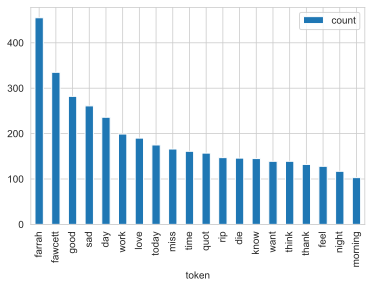

In [38]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

## Word clouds

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

In [40]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### The Word Cloud!!

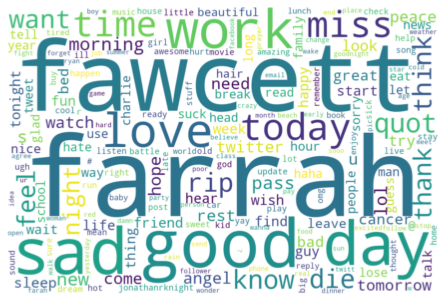

In [41]:
wordcloud(counter)

### Positive words, negative words

Let's do some charts and clouds for exclusively positive or negative samples.

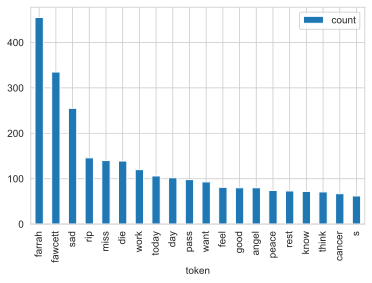

In [42]:
neg_df = df_sm[df_sm['sentiment']==0]
neg_tokens = neg_df.text_nav.map(my_tokenizer).sum()
neg_counter = Counter(neg_tokens)
#neg_counter.most_common(20)
neg_counter = Counter(remove_stopwords(neg_tokens))
neg_freq_df = pd.DataFrame.from_records(neg_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
neg_freq_df.plot(kind='bar', x='token');

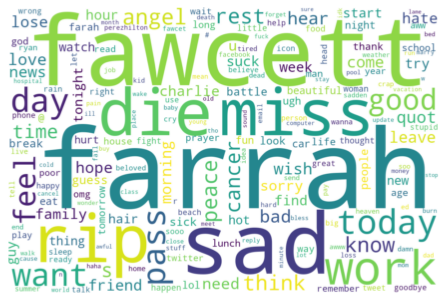

In [43]:
wordcloud(neg_counter)

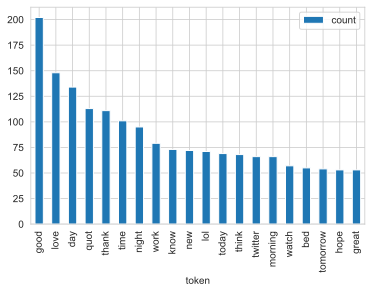

In [44]:
pos_df = df_sm[df_sm['sentiment']==4]
pos_tokens = pos_df.text_nav.map(my_tokenizer).sum()
pos_counter = Counter(pos_tokens)
#pos_counter.most_common(20)
pos_counter = Counter(remove_stopwords(pos_tokens))
pos_freq_df = pd.DataFrame.from_records(pos_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
pos_freq_df.plot(kind='bar', x='token');

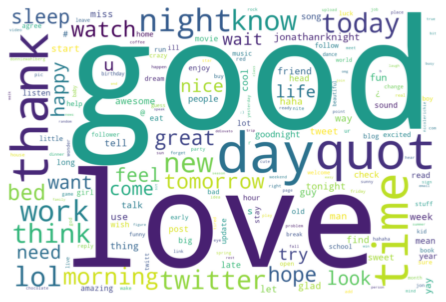

In [45]:
wordcloud(pos_counter)

Well, WOW, those are some mighty positive words, in the positive documents word cloud! 

The most frequently occurring words are clearly different in the text labeled as positive and the text labeled as negative.

In the early phases of development, we were using a dataset, centered around the change at 800,000 rows, with 4000 samples. In this sample, the words "Farrah" and "Fawcett" were the most common words. This suggested perhaps that we need to be more careful about subsampling our data (perhaps a random selection approach would yeild less weird results?) it made for a surprise when we looked at positive and negative sentiment. Who would have thought that "Farrah" and "Fawcett" would be exclusively from statements with negative sentiment? Surprised me, for sure, but there it is. Data Exploration!

## Exploring text complexity

In [46]:
df_sm['no_tokens'] = df_sm.text_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

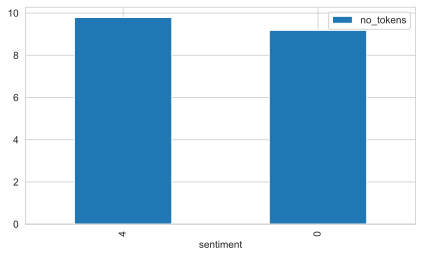

In [47]:
# mean number of tokens by sentiment
df_sm.groupby(['sentiment']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [48]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

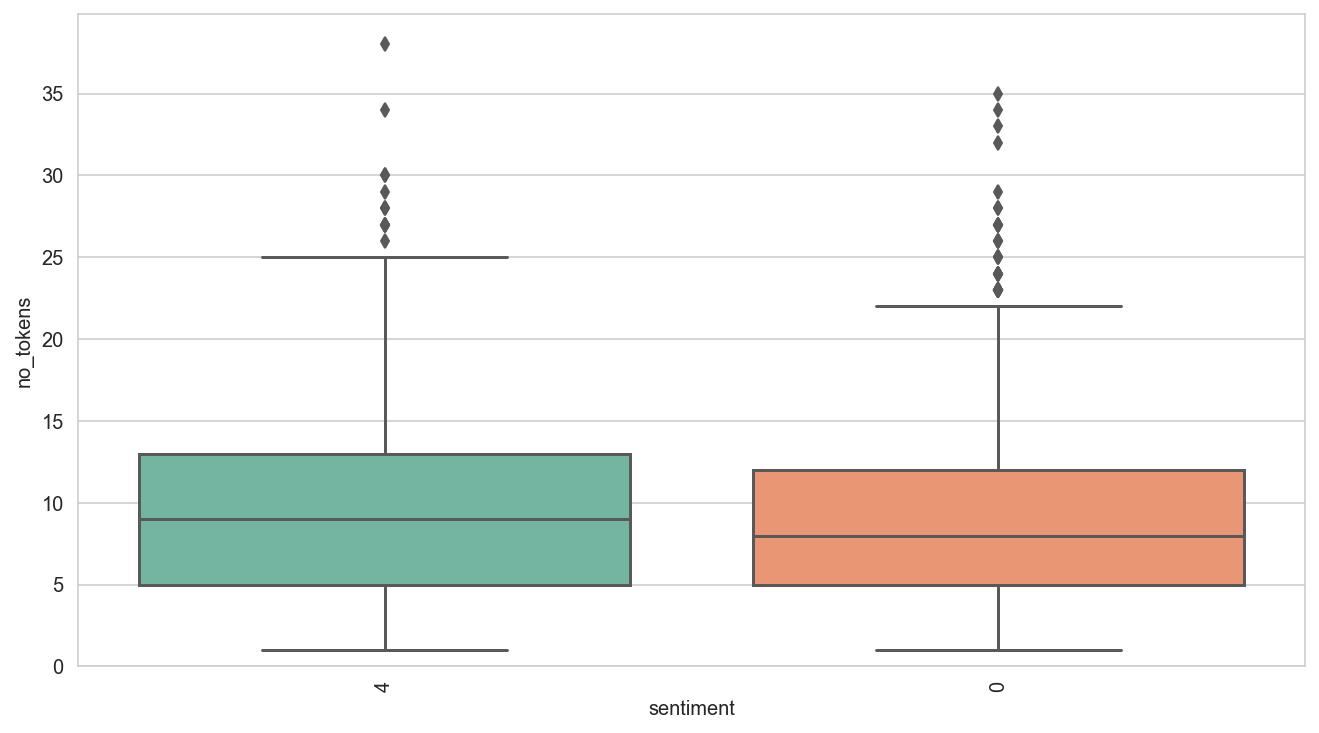

In [49]:
multi_boxplot(df_sm, 'sentiment', 'no_tokens');

In [50]:
# print text of outliers
df_sm['text_lemma'][df_sm.no_tokens > 1500]

Series([], Name: text_lemma, dtype: object)

In [51]:
# cut-off diagram at y=40

# CAREFUL!!! this isn't that meaningful, and it takes for freaking ever to plot, even with only 4000 rows!!!

# multi_boxplot(df_sm, 'username', 'no_tokens', ylim=40)

------------------------------------------

# ===============================
# Feature Engineering
# ===============================

--------------------------------------------

Feature Engineering and Feature Selection are part of the Data Preparation stage of the CRISP-DM methodology. After data has been cleaned and explored, it must be transformed from raw, unstructured text into a structured numeric format that can be used as inputs for our models. Simpler Data Engineering techniques focus on vectorizing individual words, with little emphasis on the contexts of the words. We use Bag of Words and Bag of N-Grams to explore these simpler approaches. While easy to use, and not terribly demanding in terms of computer power required, these techniques are fundamentally less powerful than more modern, processor intensive techniques that concern themselves more with the context of the words. We use pre-trained word embeddings for our advanced feature engineering efforts, in order to avoid computational bottlenecks. If time allows, we may attempt to train our own embedding at some point.

### A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute.

## Bag of Words Model

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df_sm['text_verbs'])
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [53]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,5th,absorb,accept,access,accord,account,ache,achme,acmaster27,act,add,addict,admire,admit,adore,...,workdesk,workout,worry,would,wreak,wreck,write,wtff,wtheck,wullufdude,xoxo,ya,ycse,yell,½ï
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Micro dataframe visualization experiment

To satisfy my curiosity, I'm going to make up a teeny weeny little dataframe, to see if I can see some values in one of these arrays as it gets previewed here in the pandas dataframe thing. We just see the corners. All zeroes. Let's see if it looks more satisfying with just a handful of rows...

In [54]:
df_micro = df_sm[1:10]
cv_micro = CountVectorizer(min_df=0., max_df=1.)
cv_micro_matrix = cv_micro.fit_transform(df_micro['text_nav'])
cv_micro_matrix = cv_micro_matrix.toarray()
cv_micro_matrix

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
    

In [55]:
# get all unique words in the corpus
vocab_micro = cv_micro.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_micro_matrix, columns=vocab_micro)

,age,akimbo,awful,babe,bad,be,bring,can,cartertwinszach,chapter,chichi,class,davidvancamp,day,du,...,see,sick,sorry,start,stewartwade,stop,store,sure,take,theatre,visual,wake,web,wish,would
0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Oh, that's much more gratifying!

While it's clearly useless from a practical perspective, it's nice to be able to see some numbers that aren't zeroes and let me know that the code is doing the thing I expect the code to be doing. I've got to try this on the next ones, too!

## Bag of N-Grams model

A word is just a single token, often known as a unigram or 1-gram. We already know that the Bag of Words model doesn’t consider order of words. But what if we also wanted to take into account phrases or collection of words which occur in a sequence? N-grams help us achieve that. An N-gram is basically a collection of word tokens from a text document such that these tokens are contiguous and occur in a sequence. Bi-grams indicate n-grams of order 2 (two words), Tri-grams indicate n-grams of order 3 (three words), and so on. The Bag of N-Grams model is hence just an extension of the Bag of Words model so we can also leverage N-gram based features. The following example depicts bi-gram based features in each document feature vector.

In [56]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(df_sm['text_nouns'])

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab)

,0sn argh,1000th tweet,100th annoying,1028am topic,10hrs go,10th 29th,11th cry,185k help,18a hq,18flr building,1st coffee,1st show,1st stomach,1st time,24h plane,...,zone tweet,zone way,zta due,zukyleigh madam,zurplemoon xjaeva,zzap hiding,½1 flyer,½c thï,½i guy,½n ng,½o ½c,½s poker,½s xd,½se auf,½y bay
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This gives us feature vectors for our documents, where each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.

### And now with the Micro Dataframe:

In [57]:
bv_micro = CountVectorizer(ngram_range=(2,2))
bv_micro_matrix = bv_micro.fit_transform(df_micro['text_nav'])

bv_micro_matrix = bv_micro_matrix.toarray()
vocab_micro = bv_micro.get_feature_names()
pd.DataFrame(bv_micro_matrix, columns=vocab_micro)

,age rec,akimbo ness,awful fat,babe franzi,bad wake,be feel,be go,bring know,can remember,cartertwinszach hope,chapter professional,chichi last,class miss,davidvancamp wish,day class,...,sad mad,sandrabernhard miss,schlimme miss,see fun,sick sad,sorry horrible,stewartwade pig,stop make,store age,sure great,theatre hope,visual know,web store,wish mine,would stop
0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# TF-IDF Model

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency. There are multiple variants of this model but they all end up giving quite similar results.

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df_sm['text_verbs'])
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,5th,absorb,accept,access,accord,account,ache,achme,acmaster27,act,add,addict,admire,admit,adore,...,workdesk,workout,worry,would,wreak,wreck,write,wtff,wtheck,wullufdude,xoxo,ya,ycse,yell,½ï
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3996,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3997,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3998,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Gotta try that with the Micro Dataframe...

In [59]:
tv_micro = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_micro_matrix = tv_micro.fit_transform(df_micro['text_nav'])
tv_micro_matrix = tv_micro_matrix.toarray()

vocab_micro = tv_micro.get_feature_names()
pd.DataFrame(np.round(tv_micro_matrix, 2), columns=vocab_micro)

,age,akimbo,awful,babe,bad,be,bring,can,cartertwinszach,chapter,chichi,class,davidvancamp,day,du,...,see,sick,sorry,start,stewartwade,stop,store,sure,take,theatre,visual,wake,web,wish,would
0,0.00,0.00,0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.34,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.34,0.34
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.38,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.31,0.00,0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.00,0.31,0.00,0.00,0.00,0.31,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.27,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.27,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.34,0.00,0.00,0.34,0.00,0.00,0.34,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.58,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.58,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.28,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.42,0.42,0.00,0.42,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


--------------------------------------

# ===========================
# Feature Selection
# ===========================

--------------------------------------

Feature Selection is an essential step, which allows us to identify which features are most important to the predictive abilities of our models. Filter methods of Feature Selection involve looking at individual features in isolation, giving them a score by which they can be ranked in terms of their usefulness. We use Univariate Chi-squared statistical tests. Wrapper methods of Feature Selection consider sets of features in combination, which can give deeper insights into which features to select given their interactions and correlations with one another. We use Recursive Feature Elimination and Bagged Decision Trees for this type of feature selection. There are also Embedded Feature Selection techniques, however, these are done in concert with the modeling phase of the project, and if they will be attempted, they will be attempted during the modeling phase of the project.

In [76]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Create and fit selector
selector = SelectKBest(chi2, k=50)
cv_micro_matrix_new = selector.fit_transform(cv_micro_matrix, df_micro['sentiment'])
# Get columns to keep
cols = selector.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
#features_df_new = features_df[cols]
cols


#cv_micro_matrix_new = SelectKBest(chi2, k=50).fit_transform(cv_micro_matrix, df_micro['sentiment'])

##mask = cv_micro_matrix_new.get_support()
#new_features = df_micro.columns[mask]

#vocab_selected = cv_micro_matrix_new.get_feature_names()

array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], dtype=int64)

In [77]:
pd.DataFrame(np.round(cv_micro_matrix_new, 2), columns=vocab_micro[cols])

TypeError: only integer scalar arrays can be converted to a scalar index

In [71]:
cv_matrix_new = SelectKBest(chi2, k=30).fit_transform(cv_matrix, df_sm['sentiment'])
pd.DataFrame(np.round(cv_matrix_new, 2))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3998,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Sentiment Analysis with Afinn

As a quick and dirty sanity check, I've set up Afinn in the early stages of data cleaning, and intend to keep a little record of Afinn's performance, as I increase the rigour of the data cleaning.

In [60]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [61]:
texts = np.array(df_sm['text_nav'])
sentiments = np.array(df_sm['sentiment'])

# extract data for model evaluation
#train_texts = texts[:10000]
#train_sentiments = sentiments[:10000]

#test_texts = texts[40000:60000]
#test_sentiments = sentiments[40000:60000]
sample_ids = [626, 533, 310, 123, 654, 400]

In [62]:
for text_clean, sentiment in zip(texts[sample_ids], sentiments[sample_ids]):
    print('TEXT:', texts)
    print('Actual Sentiment:', sentiment)
    print('Predicted Sentiment polarity:', afn.score(texts))
    print('-'*60)

TEXT: ['work job week slow be consider quit'
 'davidvancamp wish mine joke awful fat s would stop make'
 'chapter professional life new guess nee start' ... 'damygeebo carlis friend'
 'suzanne great twitt feel start' 'luke stephens say wonder want']
Actual Sentiment: 0


TypeError: cannot use a string pattern on a bytes-like object

In [ ]:
# Predict sentiment with Afinn

sentiment_polarity = [afn.score(Text) for Text in normalized_texts]
#predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]
predicted_sentiments = [4 if score >= 1.0 else 0 for score in sentiment_polarity]

In [ ]:
#meu.display_model_performance_metrics(true_labels=test_texts, predicted_labels=predicted_sentiments, 
#                                  classes=['positive', 'negative'])
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
                                  classes=[4, 0])

## Checking cleaning with Afinn

I'm curious about how deeper cleaning affects predicitive models. So I set up Afinn after the very first round of data cleaning, and am going to track results here in the markdown. For simplicity, I will monitor the effects of different levels of cleaning on "weighted avg f1-score"

Round 1, most basic cleaning, 20000 rows:  0.63

Round 2, include normalization, 20000 rows: 0.63

In [ ]:
df_sm.head()

## Save to database

In [ ]:
df.to_sql('df_sm', con)